# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [20]:
# Your code/answer goes here.


### Answer
1. Trạng thái ban đầu (Initial State): Là một bảng rỗng kích thước 6x7 (mặc định), tất cả các ô đều bằng 0
- Người chơi MAX được ký hiệu là 1
- Người chơi MIN được ký hiệu là -1
- Người chơi MAX luôn đi trước
2. Hành động (Actions):
Tại mỗi lượt người chơi có thể thực hiện 2 loại hành động hợp lệ:
- Nước đi bình thường (Drop move):
    - Chọn 1 cột chưa đầy
    - Đặt một quân của mình vào cột đó, quân sẽ rơi xuống ô trống thấp nhất trong cột
    - Ký hiệu hành động ("drop,c) với c là chỉ số cột
- Nước đi ác ý (mean move):
    - Chọn một quân của đối thủ nằm ở hàng dưới cùng của một cột bất kỳ
    - Lấy quân đó ra, các quân bên trễ sẽ rơi xuống một hàng.
    - Sau đó đặt chính quân đó (vẫn của đối thủ) vào bất kỳ cột nào còn chỗ trống
    - Ký hiệu hành động ("move", from_col, to_col)

3. Mô hình chuyển trạng thái (Transition Model):
Hàm chiển trạng thái result(s,a) mô tả trạng thái mới sau khi áp dụng hành động a lên trạng thái s.
- Nếu a = ("drop", c) → chèn quân của người chơi hiện tại vào cột c (ở vị trí thấp nhất còn trống).
- Nếu a = ("move", from_col, to_col) →
    - Lấy quân của đối thủ ở hàng dưới cùng của cột from_col.

    - Các quân bên trên rơi xuống một ô.

    - Đặt quân đó (vẫn thuộc về đối thủ) vào cột to_col.
4. Kiểm tra trạng thái kết thúc (Terminal test)

Trạng thái là kết thúc khi:

- Một trong hai người chơi có 4 quân liên tiếp (theo hàng ngang, dọc, hoặc chéo), hoặc

- Bảng đã đầy (không còn nước đi hợp lệ).
5. Hàm lợi ích (Utility function)

Hàm utility(s) trả về giá trị từ góc nhìn của người chơi MAX (1):
- +1 nếu MAX thắng,
- −1 nếu MIN thắng,
- 0 nếu hòa.
Nếu dùng minimax với giá trị lớn, có thể thay ±1 bằng ±∞ cho các trạng thái thắng/thua.

How big is the state space? Give an estimate and explain it.

In [21]:
# Your code/ answer goes here.

Với trò Connect 4 thông thường, số trạng thái hợp lệ khoảng:
4.53 x $10^{12}$
(theo nghiên cứu năm 1988).

Khi thêm luật “mean move” – cho phép di chuyển đĩa của đối thủ – số trạng thái khả dĩ tăng lên đáng kể, vì có thể tạo ra nhiều cấu hình khác nhau hơn.
-> Ước lượng hợp lý: Khoảng $10^{13}$ đến $10^{14}$ trạng thái

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [22]:
# Your code/ answer goes here.

Ước lượng kích thước cây trò chơi: (game tree size)
Với connect 4 chuẩn, hệ số phân nhánh trung bình b ~7 (7 cột), độ sâu tối da d<= 42 ô
Vậy kích thước cây khoảng: $7^{42}$ ≈ $10^{35}$
Với luật “mean”, mỗi lượt có thể có đến khoảng 14 hành động (7 nước “drop” + 7 nước “move”).
b ≈ 14, d<= 42 -> $14^{42} ≈ 10^{48}$
Cây trò chơi quá lớn để duyệt toàn bộ, vì vậy cần dùng thuật toán Minimax với cắt tỉa Alpha–Beta và giới hạn độ sâu để tìm kiếm hiệu quả

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [23]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board((4,4)))

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

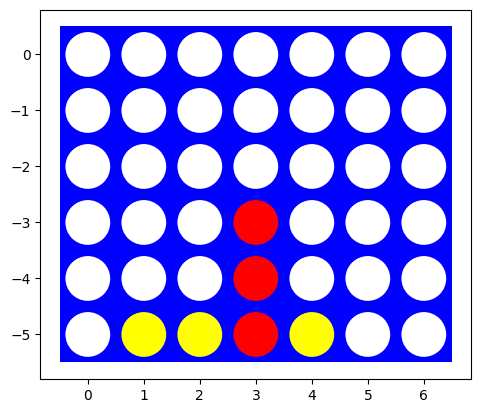

In [24]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [25]:
# Your code/ answer goes here.
def actions(board, player, move_ordering=False):
    actions_list = []
    rows, cols = board.shape

    cols_order = list(range(cols))
    if move_ordering:
        center = cols // 2
        cols_order.sort(key=lambda x: abs(x - center))

    # Drop moves
    for c in cols_order:
        if board[0, c] == 0:  # cột chưa đầy
            actions_list.append(("drop", c))

    # Mean moves
    for from_c in cols_order:
        bottom_val = board[rows-1, from_c]
        if bottom_val == -player:  # quân đối thủ ở đáy
            for to_c in cols_order:
                if board[0, to_c] == 0:  # cột đích chưa đầy
                    actions_list.append(("move", from_c, to_c))

    return actions_list
def result(board, action, player):
    new_board = np.copy(board)
    rows, cols = board.shape

    if action[0] == "drop":
        c = action[1]
        for r in range(rows-1, -1, -1):
            if new_board[r, c] == 0:
                new_board[r, c] = player
                break

    elif action[0] == "move":
        from_c, to_c = action[1], action[2]
        # Lấy quân đối thủ ở đáy
        opp_piece = new_board[rows-1, from_c]
        if opp_piece != -player:
            raise ValueError("Không thể di chuyển cột này.")
        # Dịch quân bên trên xuống
        for r in range(rows-1, 0, -1):
            new_board[r, from_c] = new_board[r-1, from_c]
        new_board[0, from_c] = 0
        # Đặt quân đối thủ vào cột đích
        for r in range(rows-1, -1, -1):
            if new_board[r, to_c] == 0:
                new_board[r, to_c] = opp_piece
                break

    return new_board
def check_four(board, player):
    rows, cols = board.shape

    # Kiểm tra ngang
    for r in range(rows):
        for c in range(cols - 3):
            if all(board[r, c+i] == player for i in range(4)):
                return True
    # Kiểm tra dọc
    for c in range(cols):
        for r in range(rows - 3):
            if all(board[r+i, c] == player for i in range(4)):
                return True
    # Kiểm tra chéo xuống
    for r in range(rows - 3):
        for c in range(cols - 3):
            if all(board[r+i, c+i] == player for i in range(4)):
                return True
    # Kiểm tra chéo lên
    for r in range(3, rows):
        for c in range(cols - 3):
            if all(board[r-i, c+i] == player for i in range(4)):
                return True
    return False


def terminal(board):
    if check_four(board, 1) or check_four(board, -1):
        return True
    if not any(board[0, c] == 0 for c in range(board.shape[1])):  # full board
        return True
    return False
def utility(board):
    if check_four(board, 1):
        return 1
    elif check_four(board, -1):
        return -1
    else:
        return 0


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [26]:
# Your code/ answer goes here.
import random

def random_player(board, player=1):
    possible_actions = actions(board, player)
    return random.choice(possible_actions)

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [27]:
# Your code/ answer goes here.
def play_game(agent1, agent2, shape=(6,7)):
    board = empty_board(shape)
    player = 1
    while not terminal(board):
        if player == 1:
            action = agent1(board, player)
        else:
            action = agent2(board, player)
        board = result(board, action, player)
        player *= -1
    return utility(board)

def simulate_random_games(n=1000):
    results = {1:0, -1:0, 0:0}
    for _ in range(n):
        u = play_game(random_player, random_player)
        results[u] += 1
    return results

print(simulate_random_games(100))

{1: 81, -1: 19, 0: 0}


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [28]:
# Your code/ answer goes here.
import math

def maximum(board, player, alpha, beta, move_ordering=False, depth = 3):
    if terminal(board=board) or depth == 0:
        return utility(board), None

    v0, move = -math.inf, None
    for action in actions(board, player, move_ordering):
        v, _= minimum(result(board, action, player), -player, alpha, beta, move_ordering, depth-1)
        if v > v0:
            v0 = v
            move = action
            alpha = max(alpha, v0)
        if v >= beta:
            break

    return v0, move


def minimum(board, player, alpha, beta, move_ordering=False, depth = 3):
    if terminal(board=board) or depth == 0:
        return utility(board), None

    v0, move = math.inf, None
    for action in actions(board, player, move_ordering):
        v, _ = maximum(result(board, action, player), -player, alpha, beta, move_ordering, depth-1)
        if v < v0:
            v0 = v
            move = action
            beta = min(beta, v0)
        if v <= alpha:
            break

    return v0, move

def alpha_beta_search(board, player = 1):
    if player == 1:
        value, move = maximum(board, player, -math.inf, +math.inf)
    else:
        value, move = minimum(board, player, -math.inf, +math.inf)
    return value, move

def play_game_minimax(board, alpha, beta):
    board = board
    player = 1
    while not terminal(board):
        if player == 1:
            _, action = maximum(board, player, alpha, beta, True)
        else:
            action = random_player(board, player)
        board = result(board, action, player)
        player *= -1
    return utility(board)

def simulate_games(n, board):
    results = {1:0, -1:0, 0:0}
    for _ in range(n):
        u = play_game_minimax(board, -math.inf, +math.inf)
        results[u] += 1
    return results


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

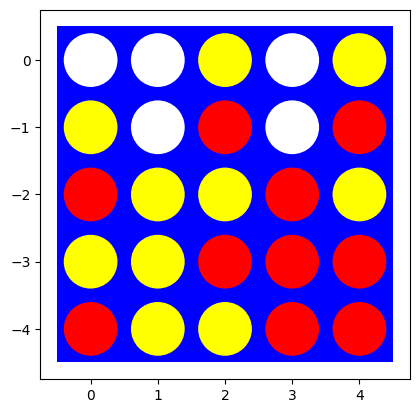

CPU times: user 11 ms, sys: 3 µs, total: 11 ms
Wall time: 11.2 ms


(1, ('drop', 3))

In [29]:
# Your code/ answer goes here.
board = [[0, 0, -1, 0, -1],
         [-1, 0, 1, 0, 1],
         [1, -1, -1, 1, -1],
         [-1, -1, 1, 1, 1],
         [1, -1, -1, 1, 1]]

board = np.array(board)

visualize(board)
%time alpha_beta_search(board)

# the agent spots winning opportunity at column 3

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [30]:
# Your code/ answer goes here.
# board = [[0, 0, 0, 0],
#          [-1, 1, -1, 1],
#          [1, -1, 1, -1],
#          [-1, -1, 1, 1]]
# board = np.array(board)

# visualize(board)

# %time alpha_beta_search(board)

# The agent take 12.8ms to make a move

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

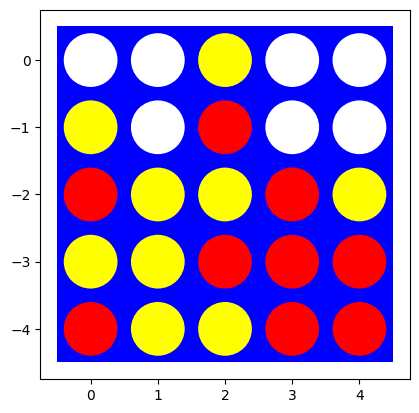

(1, ('drop', 1))
(1, ('drop', 1))
Using move ordering took: 241.31011962890625 miliseconds
Without move ordering took: 611.7370128631592 miliseconds


In [31]:
# Your code/ answer goes here.
# Move Ordering

# Trong thuật toán Alpha-Beta pruning, hiệu quả cắt tỉa phụ thuộc vào thứ tự duyệt các nước đi.
# Chiến lược Move Ordering giúp sắp xếp nước đi sao cho các lựa chọn tiềm năng cao được xét trước, qua đó tăng khả năng cập nhật nhanh giá trị alpha và beta.

# Trong bài này, ta sử dụng chiến lược center-first, ưu tiên các cột ở trung tâm vì chúng thường tạo ra nhiều hướng thắng hơn trong trò Mean Connect-4.

import time
board = [[0, 0, -1, 0, 0],
         [-1, 0, 1, 0, 0],
         [1, -1, -1, 1, -1],
         [-1, -1, 1, 1, 1],
         [1, -1, -1, 1, 1]]

board = np.array(board)

visualize(board)
t0 = time.time()
print(maximum(board, 1, -math.inf, +math.inf, True, 10))
t1 = time.time()
print(maximum(board, 1, -math.inf, +math.inf, False, 10))
t2 = time.time()

print(f"Using move ordering took: {(t1 - t0) * 1e3} miliseconds")
print(f"Without move ordering took: {(t2 - t1) * 1e3} miliseconds")



### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [32]:
# Your code/ answer goes here.
# Khi bắt đầu với bàn cờ trống, thuật toán Minimax với Alpha-Beta pruining phải duyệt qua hầu hết các trạng thái khả thi vì chưa có thông tin nào để cắt tỉa. Điều này khiến cho
# thời gian tìm kiếm bước đầu tiên tăng đột biến.
# Để giải quyết vấn đề này, ta có thể áp dụng các chiến lược tối ưu như sau:
# 1. Sử dụng depth limited và heuristic để đánh giá các trạng thái trung gian, giúp giảm độ sâu tìm kiếm và thời gian xử lý.
# 2. Áp dụng move ordering để ưu tiên các nước đi tiềm năng.
# 3. Dùng bảng lưu trạng thái (transposition table) để tránh tính lại những vị trí đã gặp.


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

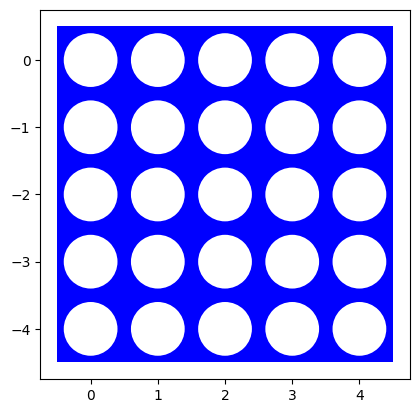

{1: 82, -1: 18, 0: 0}


{1: 100, -1: 0, 0: 0}

In [33]:
# Your code/ answer goes here.

board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]

board = np.array(board)

visualize(board)
print(simulate_random_games(100))

simulate_games(100, board)
# the Minimax Search agent is much smarter than the random agent and it won 100/100 matches.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [34]:
# Your code/ answer goes here.

import math

def heuristic(state, player = 1, more_weight=False):
    u = utility(state)
    if u != 0:
        return u, True

    score = 0
    rows, cols = state.shape
    opponent = -player

    center_col = cols // 2
    center_arr = state[:, center_col]
    score += 0.1*np.sum(center_arr == player)
    if more_weight:
        score *= 2

    # Duyệt dọc
    for c in range(cols):
        for r in range(rows-3):
            window = state[r:r+4, c]
            score += evaluate_window(window, player, opponent)

    # Duyệt ngang
    for r in range(rows):
        for c in range(cols - 3):
            window = state[r, c:c+4]
            score += evaluate_window(window, player, opponent)

    # # Duyệt chéo phải
    for r in range(rows - 3):
        for c in range(cols - 3):
            window = np.array([state[r+i, c+i] for i in range(4)])
            score += evaluate_window(window, player, opponent)

    # Duyệt chéo trái
    for r in range(rows - 3):
        for c in range(3, cols):
            window = np.array([state[r+i, c-i] for i in range(4)])
            score += evaluate_window(window, player, opponent)

    score = max(-1.0, min(1.0, score))
    return score, False


def evaluate_window(window, player, opponent):
    score = 0
    play_count = np.sum(window == player)
    opp_count = np.sum(window == opponent)
    empty_count = np.sum(window == 0)

    if play_count == 4:
        score += 1.0
    elif play_count == 3 and empty_count == 1:
        score += 0.1
    elif play_count == 2 and empty_count == 2:
        score += 0.01
    elif opp_count == 3 and empty_count == 1:
        score -= 0.12
    elif opp_count == 2 and empty_count == 2:
        score -= 0.015

    return score


def heuristic_maximum(board, player, alpha, beta, move_ordering=False, depth = 4, more_weight=False):
    v, terminal_state = heuristic(board, player, more_weight)

    if terminal_state or depth == 0:
        if terminal_state:
            alpha, beta = v, v
        return v, None
    v, move = -math.inf, None
    for action in actions(board, player, move_ordering):

        value, _ = heuristic_minimum(result(board, action, player), -player, alpha, beta, move_ordering, depth-1, more_weight)
        if value > v:
            v = value
            move = action
            alpha = max(alpha, v)
        if v >= beta:
            return v, move
    return v, move

def heuristic_minimum(board, player, alpha, beta, move_ordering=False, depth = 4, more_weight=False):
    v, terminal_state = heuristic(board, player, more_weight)
    if terminal_state or depth == 0:
        if terminal_state:
            alpha, beta = v, v
        return v, None
    v, move = +math.inf, None
    for action in actions(board, player, move_ordering):
        value, _ = heuristic_maximum(result(board, action, player), -player, alpha, beta, move_ordering, depth-1, more_weight)
        if value < v:
            v = value
            move = action
            beta = min(beta, v)
        if v <= alpha:
            return v, move
    return v, move

def heuristic_alpha_beta_search(board, player=1, move_ordering= False, depth=4, more_weight=False):
    if player == 1:
        value, move = heuristic_maximum(board, player, -math.inf, +math.inf, move_ordering, depth, more_weight)
    else:
        value, move = heuristic_minimum(board, player, -math.inf, +math.inf, move_ordering, depth, more_weight)
    return value, move

def play_game_heuristic_minimax(board, alpha, beta, move_ordering=False, depth=4):
    board = board
    player = 1
    while not terminal(board):
        if player == 1:
            action, _ = heuristic_alpha_beta_search(board, player, alpha, beta, move_ordering, depth)
        else:
            action, _ = heuristic_alpha_beta_search(board, player, alpha, beta, move_ordering, depth)
        board = result(board, action, player)
        player *= -1
    return utility(board)

def simulate_heuristic_games(n, board, move_ordering = False, depth=4):
    results = {1:0, -1:0, 0:0}
    for _ in range(n):
        u = play_game_heuristic_minimax(board, -math.inf, +math.inf, move_ordering, depth)
        results[u] += 1
    return results


### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

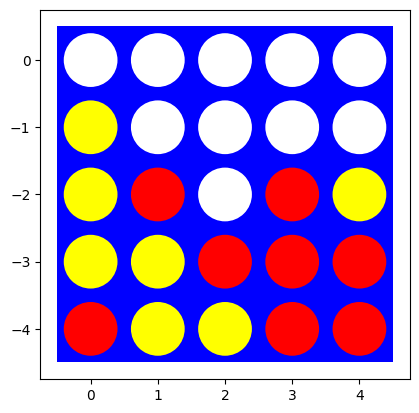

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 149 ms


(1, ('drop', 3))

In [35]:
# Your code/ answer goes here.
board = [[0, 0, 0, 0, 0],
         [-1, 0, 0, 0, 0],
         [-1, 1, 0, 1, -1],
         [-1, -1, 1, 1, 1],
         [1, -1, -1, 1, 1]]

board = np.array(board)
visualize(board)

%time heuristic_alpha_beta_search(board, player=1, move_ordering=True, depth=4)

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

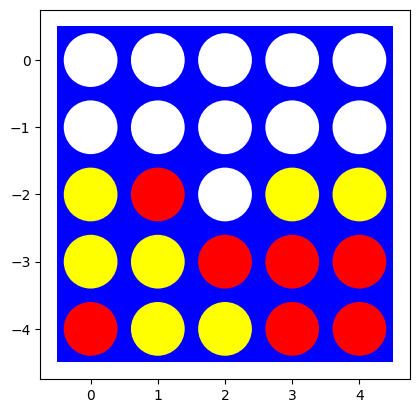

CPU times: user 226 ms, sys: 2.01 ms, total: 228 ms
Wall time: 230 ms


(1, ('drop', 2))

In [36]:
# Your code/ answer goes here.
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [-1, 1, 0, -1, -1],
         [-1, -1, 1, 1, 1],
         [1, -1, -1, 1, 1]]

board = np.array(board)
visualize(board)
%time heuristic_alpha_beta_search(board, player=1, move_ordering=True, depth=4)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [37]:
# Your code/ answer goes here.
# With a state above, it takes 254ms to make a move

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

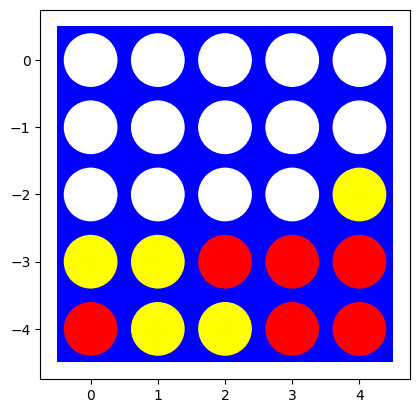

CPU times: user 2.41 s, sys: 2.12 ms, total: 2.41 s
Wall time: 2.41 s


1

In [38]:
# Your code/ answer goes here.
board = [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, -1],
         [-1, -1, 1, 1, 1],
         [1, -1, -1, 1, 1]]

board = np.array(board)
visualize(board)

def play_game_heuristic_minimax(board, move_ordering=False, depth=4):
    board = board
    player = 1
    while not terminal(board):
        if player == 1:
            _, action  = heuristic_alpha_beta_search(board, player,
                                                    move_ordering,
                                                    depth,
                                                    more_weight=True)
        else:
            _, action = heuristic_alpha_beta_search(board, player,
                                                    move_ordering,
                                                    depth-2,
                                                    more_weight=False)
        board = result(board, action, player)
        player *= -1
    return utility(board)

%time play_game_heuristic_minimax(board, True, 4)
# %time heuristic_alpha_beta_search(board, move_ordering= True)


## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above.

In [39]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [40]:
# Your code/ answer goes here.